# Test Runs for Merging Changes

This notebook is used for testing changes made to the master branch, by running the models in base/model (which should be identical to the master branch) and changes/model (which should be the model run with your changes) 

Please follow the procedure described in the [readme](../../../README.md), and be critical if the tests performed here is enough to verify and validate the changes made. Furthermore, note the following:
- Make sure that the choice of addons is comparable, unless the change is a new addon
- If the changes are in files that by default are loaded in the base scenario (such as addons) you will need to apply the changes through options. Or, more simply, run the four tests manually in other folders and copy+paste the relevant MainResults to the paths expected by this script and append -lowtemphighspace and -hightemplowspace to the respective files. Skip to the analysis section below in that case.
- If a GamsExecutionError occur in the cell running Balmorel, check the _gams_py_gjo0.lst file, or maybe try to run the scenario in GAMS studio for easier debugging
- All tests may take around 45 minutes.

The [pybalmorel](https://pypi.org/project/pybalmorel/) package is required to run this notebook. In a terminal, create a new python environment, activate it and install version 0.2.2 by running the following command:
```
pip install pybalmorel==0.2.2
```
Documentation on creating and activating virtual environments for standalone python can be found [here](https://docs.python.org/3/library/venv.html) and for a conda installation [here](https://docs.conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html).

You may also consider installing nbconvert for converting the results from the notebook into a distributable .pdf, using the following commands:
```
pip install nbconvert
cd base/auxils/master_merge_tests
jupyter nbconvert --to pdf merge_tests.ipynb
```


In [1]:
from pybalmorel import MainResults, IncFile
from gams import GamsWorkspace
import pandas as pd
import numpy as np
import os

## Scenario and test case names
scenarios = ['base', 'merge']
test_cases = ['lowtemphighspace', 'hightemplowspace']

## Run Balmorel

The following section runs the base and changes scenario at different resolutions:
1. Low temporal resolution (Two seasons with four hours each) and high spatial resolution (the existing resolution in each C file)
2. High temporal resolution (Four seasons with all hours) and low spatial resolution (only Denmark and Norway) 

In [ ]:
### 1.0 Prepare .inc-file formats for test cases
C = IncFile(name='C',
            prefix="SET C(CCC)  'Countries in the simulation'\n/\n",
            suffix="\n/;",
            )
Y = IncFile(name='Y',
            prefix="SET  Y(YYY) 'Years in the simulation'\n/\n",
            suffix="\n/;",
            )
S = IncFile(name='S',
            prefix="SET S(SSS)  'Seasons in the simulation'\n/\n",
            suffix="\n/;",
            )
T = IncFile(name='T',
            prefix="SET T(TTT)  'Time periods within a season in the simulation'\n/\n",
            suffix="\n/;",
            )

### 1.1 Running Balmorel Test Cases
for scenario in scenarios:
    for test_case in test_cases:
        
        # Set resolutions
        C.path ='../../../%s/data'%scenario
        Y.path ='../../../%s/data'%scenario
        S.path ='../../../%s/data'%scenario
        T.path ='../../../%s/data'%scenario
        if test_case == 'lowtemphighspace':
            # keep the country resolution of the base and change in this case
            Y.body = "2030, 2050"
            S.body = "S01, S26"
            T.body = "T073, T079, T085, T091"
            
            # rename original temporal .inc-files so they're not lost
            try:
                os.rename('../../../%s/data/Y.inc'%scenario,
                        '../../../%s/data/Y_old.inc'%scenario)
                os.rename('../../../%s/data/S.inc'%scenario,
                        '../../../%s/data/S_old.inc'%scenario)
                os.rename('../../../%s/data/T.inc'%scenario,
                        '../../../%s/data/T_old.inc'%scenario)
            except (FileNotFoundError, FileExistsError):
                print('Possibly already renamed old resolution .inc-files')
                
        elif test_case == 'hightemplowspace':
            C.body = "DENMARK, NORWAY"
            Y.body = "2030, 2050"
            S.body = "S01, S14, S27, S40"
            T.body = "T001*T168"
            
            # rename original C .inc-file so it's not lost
            try:
                os.rename('../../../%s/data/C.inc'%scenario,
                        '../../../%s/data/C_old.inc'%scenario)
            except (FileNotFoundError, FileExistsError):
                print('Possibly already renamed old resolution .inc-files')
                
            C.save()
        Y.save()
        S.save()
        T.save()
        
        # Run Balmorel
        ws = GamsWorkspace(working_directory='../../../%s/model'%scenario)

        job = ws.add_job_from_file(os.path.join(os.path.abspath('../../../%s/model'%scenario), 'Balmorel'))
        out = job.run()
        
        # Check feasibility
        with open('../../../%s/model/_gams_py_gjo0.lst'%scenario, 'r') as f:
            output = pd.Series(f.readlines())

        output = output[output.str.find('LP status') != -1] # Find all status
        all_feasible = output[output.str.find('infeasible') != -1].empty # Check if none are infeasible
        if not(all_feasible):
            raise Exception('Model run infeasible!')
        
        # Rename MainResults
        try:
            os.rename('../../../%s/model/MainResults.gdx'%scenario,
                    '../../../%s/model/MainResults_%s.gdx'%(scenario, test_case))
        except FileExistsError:
            print('Previous run existed, overwriting')
            os.replace('../../../%s/model/MainResults.gdx'%scenario,
                    '../../../%s/model/MainResults_%s.gdx'%(scenario, test_case))
        

## Analysis

General results are compared between scenarios for each test case and KPI's are calculated on production of commodities and capacities. 

In [11]:
### 2.0 Load Results
mr = MainResults(files=['MainResults_%s-%s.gdx'%(scenario, test_case) for test_case in test_cases for scenario in scenarios],
                 paths=['../../../base/model'])


# A convenient function for printing scenario results
def print_results(res: pd.DataFrame,
                  name: str,
                  unit: str,
                  scenarios: list,
                  test_cases: list,
                  seperator: str = '-'):
    print('All %s [%s]:\n---------------------\n'%(name, unit))
    print(scenarios[0]+seperator+test_cases[0]+'\n', res[scenarios[0]+seperator+test_cases[0]].to_string(), '\n')
    print(scenarios[1]+seperator+test_cases[0]+'\n', res[scenarios[1]+seperator+test_cases[0]].to_string(), '\n')
    print(scenarios[0]+seperator+test_cases[1]+'\n', res[scenarios[0]+seperator+test_cases[1]].to_string(), '\n')
    print(scenarios[1]+seperator+test_cases[1]+'\n', res[scenarios[1]+seperator+test_cases[1]].to_string(), '\n')
    for test_case in test_cases:
        print('\nDifference in %s in %s between %s and %s in for %s'%tuple([name, unit] + scenarios + [test_case]),
            '\n-------------------------------------------------------------\n')
        print((res['%s%s%s'%(scenarios[1], seperator, test_case)] - res['%s%s%s'%(scenarios[0], seperator, test_case)]).to_string() + '\n')

In [23]:
### 2.1 Calculate Difference in production 
pro = mr.get_result('PRO_YCRAGF').pivot_table(index='Year',
                                              columns=['Scenario', 'Commodity'],
                                              values='Value',
                                              aggfunc='sum')
print_results(pro, 'production', 'TWh', scenarios, 
              test_cases, '-')

All production [TWh]:
---------------------

base-lowtemphighspace
 Commodity  ELECTRICITY         HEAT     HYDROGEN
Year                                            
2030       2869.276366  3796.358465   462.710060
2050       4667.655580  3761.749433  2271.927144 

merge-lowtemphighspace
 Commodity  ELECTRICITY         HEAT     HYDROGEN
Year                                            
2030       4077.090418  6270.953211   380.805021
2050       6399.080581  6354.479388  2054.303374 

base-hightemplowspace
 Commodity  ELECTRICITY       HEAT   HYDROGEN
Year                                        
2030        156.270829  96.187924  14.371776
2050        181.412084  96.652686  30.780696 

merge-hightemplowspace
 Commodity  ELECTRICITY        HEAT   HYDROGEN
Year                                         
2030        202.787943  141.563107  30.989462
2050        255.147313  142.961660  52.440355 


Difference in production in TWh between base and merge in for lowtemphighspace 
----------------

In [21]:
### 2.2 Calculate Difference in Generation Capacities
cap = mr.get_result('G_CAP_YCRAF')
sto = cap[(cap.Technology != 'INTRASEASONAL-ELECT-STORAGE') &\
        (cap.Technology != 'INTRASEASONAL-HEAT-STORAGE') &\
        (cap.Technology != 'INTERSEASONAL-HEAT-STORAGE') &\
        (cap.Technology != 'H2-STORAGE')].pivot_table(index='Year',
                                                            columns=['Scenario', 'Commodity'],
                                                            values='Value',
                                                            aggfunc='sum').fillna(0)

print_results(cap, 'generation capacities', 'GW',
              scenarios, test_cases, '-')

All generation capacities [GW]:
---------------------

base-lowtemphighspace
 Commodity  BIOMETHANE  ELECTRICITY        HEAT    HYDROGEN
Year                                                      
2030              0.0  1184.316253  872.802042   78.378683
2050              0.0  2400.204859  904.004898  720.042070 

merge-lowtemphighspace
 Commodity  BIOMETHANE  ELECTRICITY         HEAT    HYDROGEN
Year                                                       
2030              0.0  1517.904883  1433.982852   69.632680
2050              0.0  2948.762527  1486.044890  496.115835 

base-hightemplowspace
 Commodity  BIOMETHANE  ELECTRICITY       HEAT  HYDROGEN
Year                                                   
2030              0.0    43.789295  22.090175  2.002775
2050              0.0    55.038155  20.737092  4.588077 

merge-hightemplowspace
 Commodity  BIOMETHANE  ELECTRICITY       HEAT  HYDROGEN
Year                                                   
2030              0.0    60.92562

In [98]:
### 2.3 Calculate Difference in Storage Capacities
sto = mr.get_result('G_STO_YCRAF').pivot_table(index='Year',
                                        columns=['Scenario', 'Commodity'],
                                        values='Value',
                                        aggfunc='sum').fillna(0)

print_results(sto, 'storage capacities', 'GWh',
              scenarios, test_cases, '-')

All storage capacities [GWh]:
---------------------

base-lowtemphighspace
 Commodity    ELECTRICITY         HEAT     HYDROGEN
Year                                              
2030       150785.604830  5658.100859   133.260319
2050       150811.535739  6295.868270  1877.621283 

merge-lowtemphighspace
 Commodity    ELECTRICITY         HEAT      HYDROGEN
Year                                               
2030       154516.600913  3386.836873   1321.136951
2050       154516.591163  5483.830111  37996.758448 

base-hightemplowspace
 Commodity  ELECTRICITY        HEAT
Year                              
2030           82224.0  276.061581
2050           82224.0  282.360567 

merge-hightemplowspace
 Commodity   ELECTRICITY        HEAT    HYDROGEN
Year                                           
2030       82224.000000  346.112568  160.332297
2050       82227.718875  384.193272  161.453957 


Difference in storage capacities in GWh between base and merge in for lowtemphighspace 
------------

In [24]:
### 2.4 Calculate Difference in Transmission Capacities
eltran = mr.get_result('X_CAP_YCR').pivot_table(index='Year',
                                        columns=['Scenario'],
                                        values='Value',
                                        aggfunc=lambda x: np.sum(x)/2).fillna(0) # Remember to divide by two

print_results(eltran, 'electricity transmission capacities',
              'GW', scenarios, test_cases, '-')

All electricity transmission capacities [GW]:
---------------------

base-lowtemphighspace
 Year
2030    150.755000
2050    160.333522 

merge-lowtemphighspace
 Year
2030    188.510500
2050    541.084679 

base-hightemplowspace
 Year
2030    11.077000
2050    15.760916 

merge-hightemplowspace
 Year
2030    11.077000
2050    16.103629 


Difference in electricity transmission capacities in GW between base and merge in for lowtemphighspace 
-------------------------------------------------------------

Year
2030     37.755500
2050    380.751157


Difference in electricity transmission capacities in GW between base and merge in for hightemplowspace 
-------------------------------------------------------------

Year
2030    0.000000
2050    0.342713



In [26]:
### 2.5 Objective Costs
obj = mr.get_result('OBJ_YCR').pivot_table(index='Year',
                                        columns='Scenario',
                                        values='Value',
                                        aggfunc='sum').fillna(0) 

print_results(obj, 'System Costs',
              'M€', scenarios, test_cases, '-')


All System Costs [M€]:
---------------------

base-lowtemphighspace
 Year
2030    127992.022313
2050    177372.000352 

merge-lowtemphighspace
 Year
2030    229190.203460
2050    306418.752372 

base-hightemplowspace
 Year
2030    2626.881407
2050    3121.342709 

merge-hightemplowspace
 Year
2030    5062.975367
2050    6482.092058 


Difference in System Costs in M€ between base and merge in for lowtemphighspace 
-------------------------------------------------------------

Year
2030    101198.181147
2050    129046.752020


Difference in System Costs in M€ between base and merge in for hightemplowspace 
-------------------------------------------------------------

Year
2030    2436.093960
2050    3360.749349



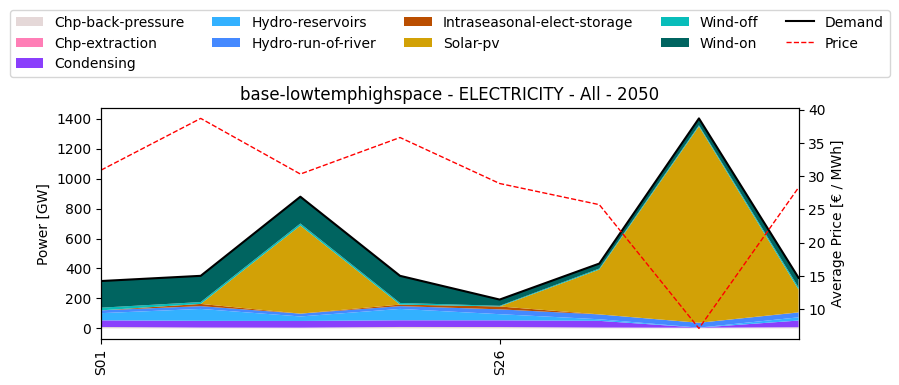

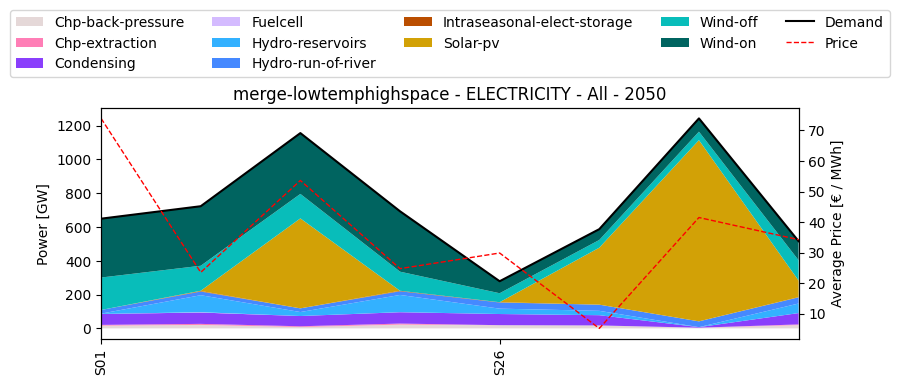

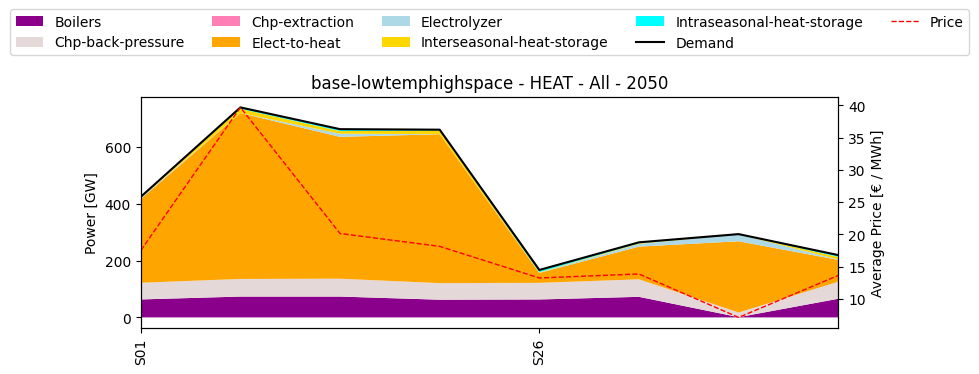

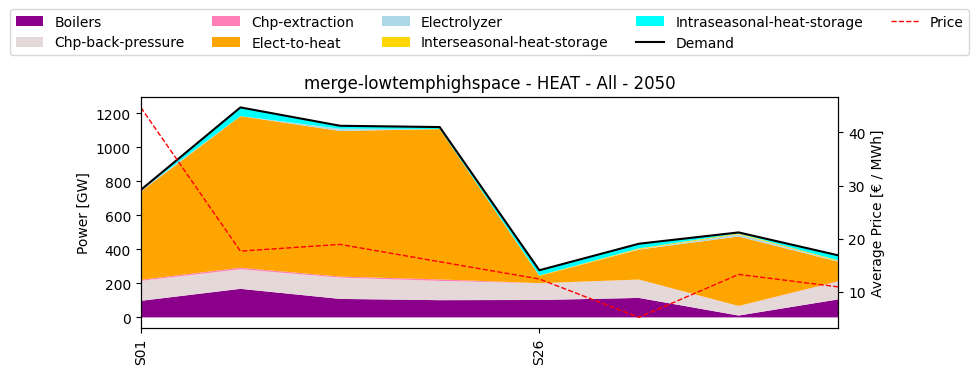

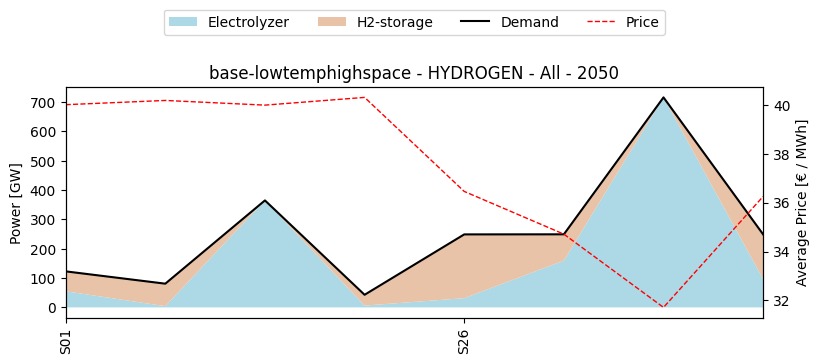

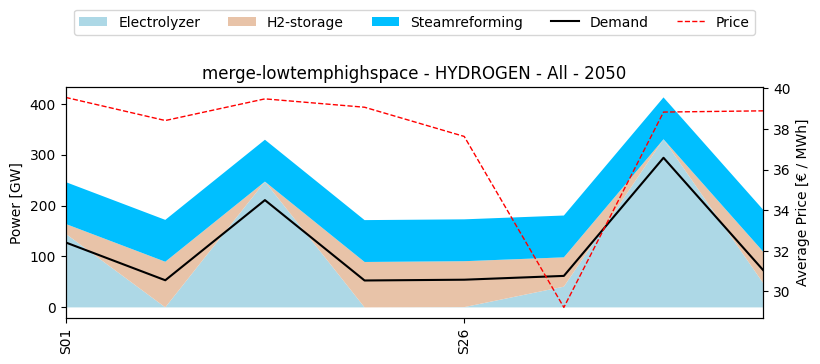

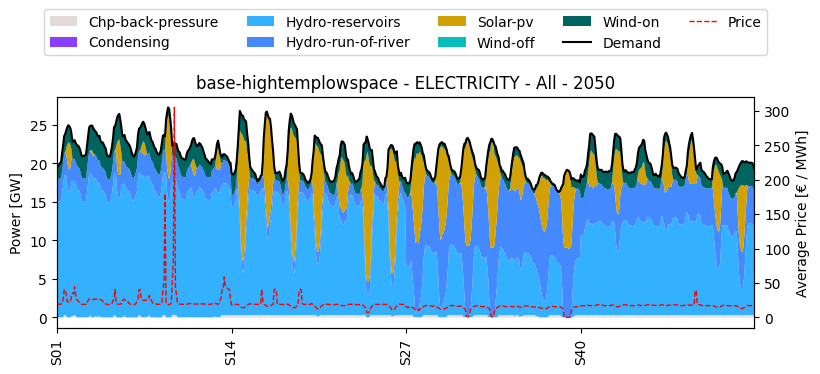

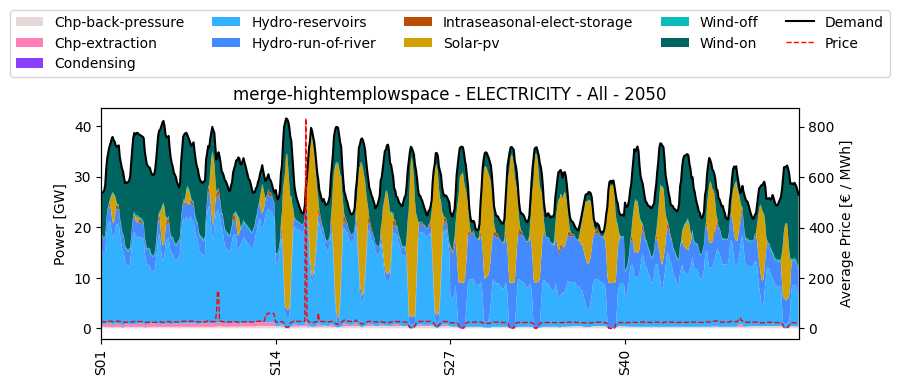

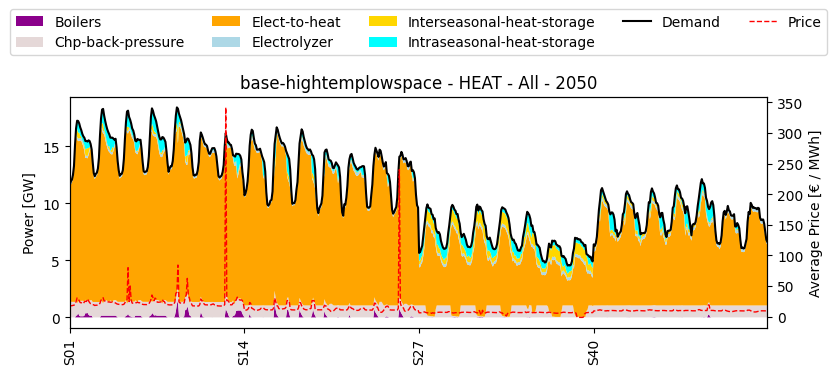

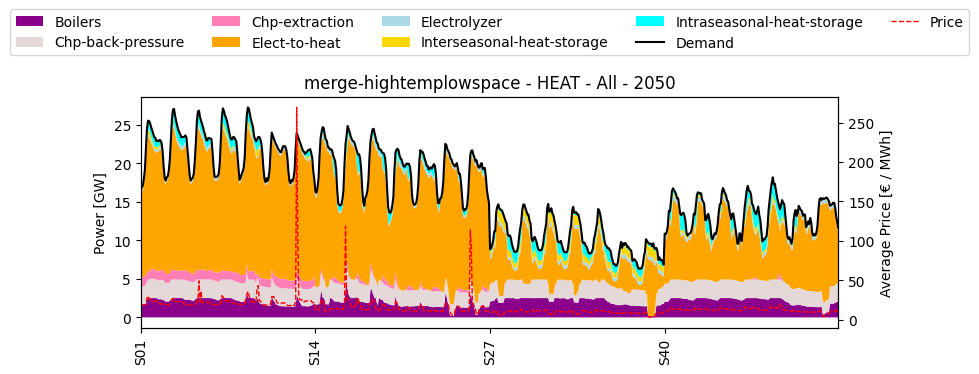

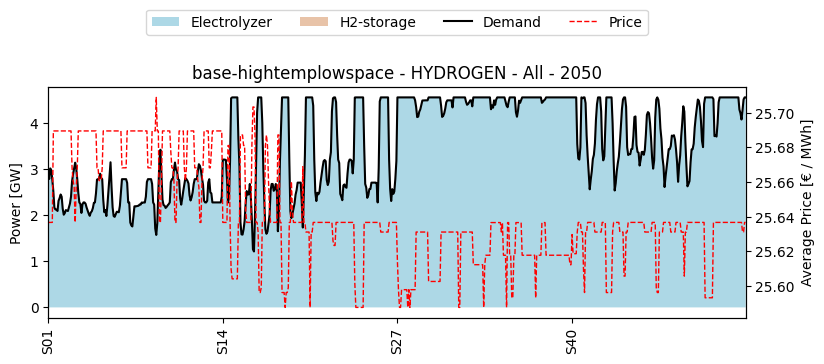

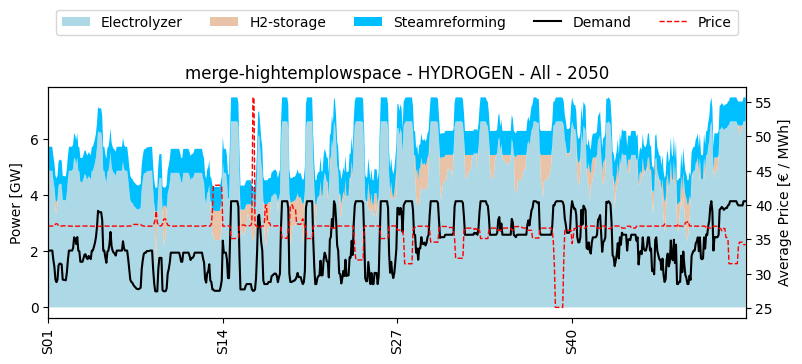

In [24]:
### 2.6 Profiles
for test_case in test_cases:
    for carrier in ['electricity', 'heat', 'hydrogen']:
        for scenario in scenarios:
            mr.plot_profile(carrier, 2050, '%s-%s'%(scenario, test_case))

Found MainResults in ../../../base/model\MainResults_base-lowtemphighspace.gdx
Found MainResults in ../../../base/model\MainResults_merge-lowtemphighspace.gdx
Found MainResults in ../../../base/model\MainResults_base-lowtemphighspace.gdx
Found MainResults in ../../../base/model\MainResults_merge-lowtemphighspace.gdx
Found MainResults in ../../../base/model\MainResults_base-hightemplowspace.gdx
Found MainResults in ../../../base/model\MainResults_merge-hightemplowspace.gdx
Found MainResults in ../../../base/model\MainResults_base-hightemplowspace.gdx
Found MainResults in ../../../base/model\MainResults_merge-hightemplowspace.gdx


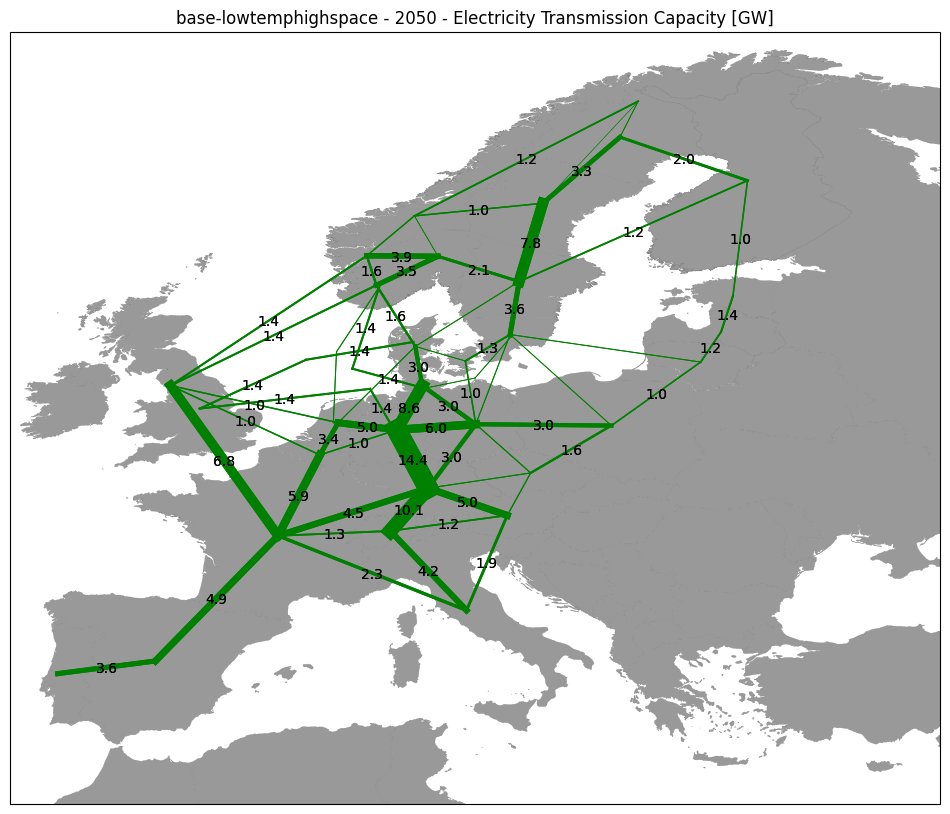

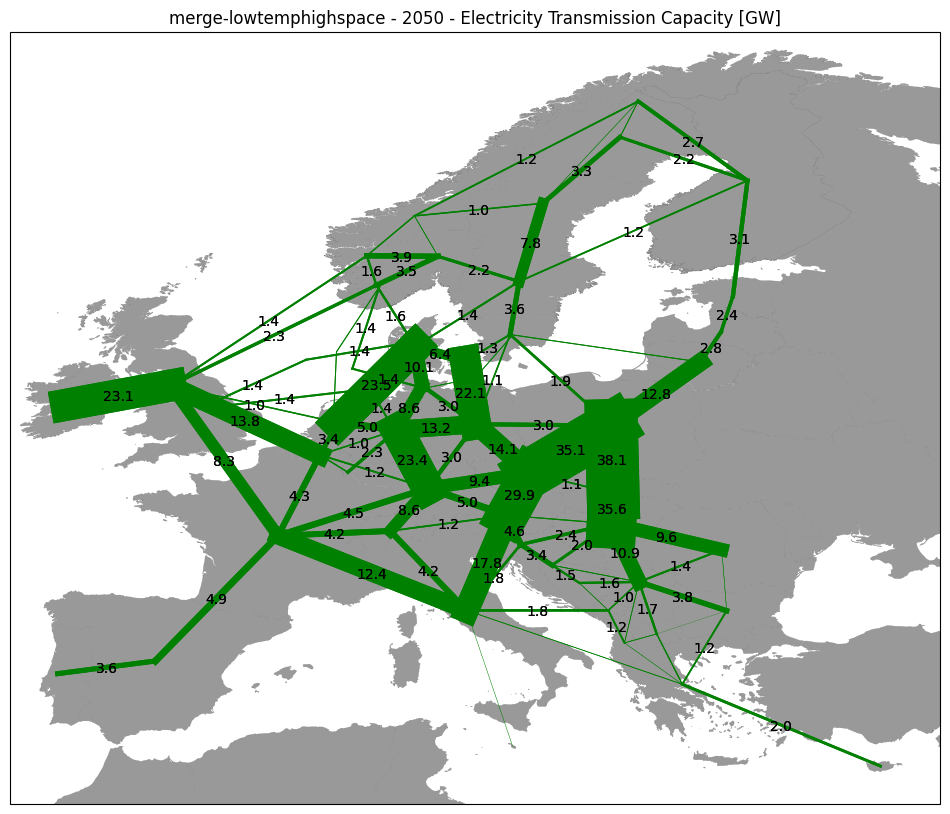

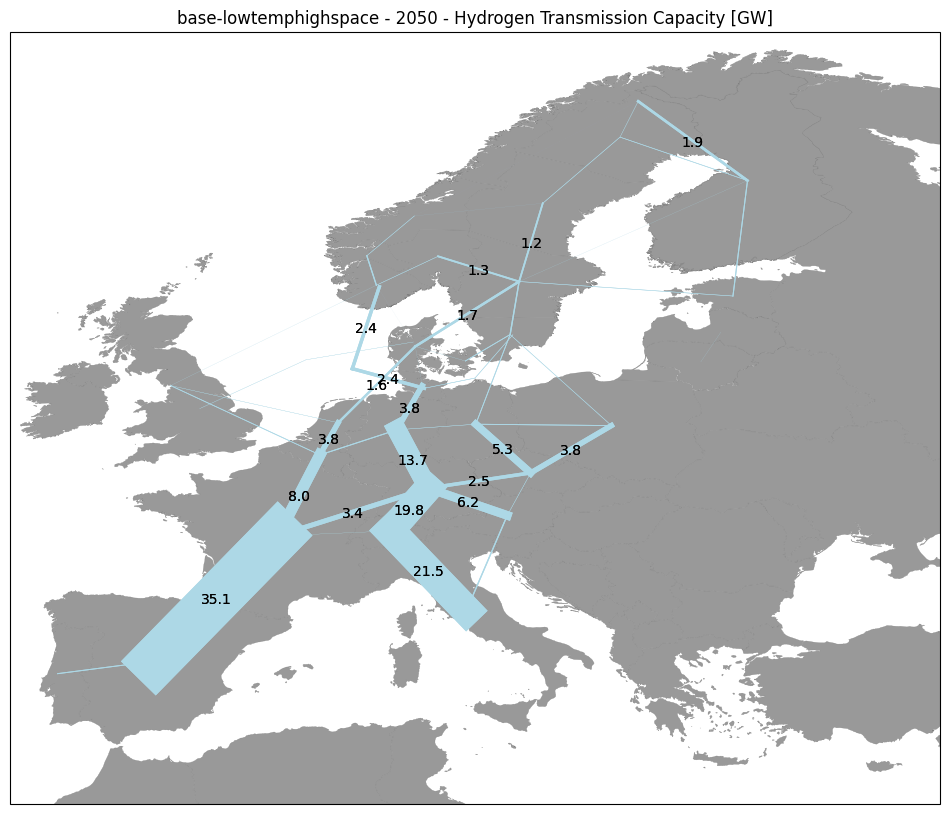

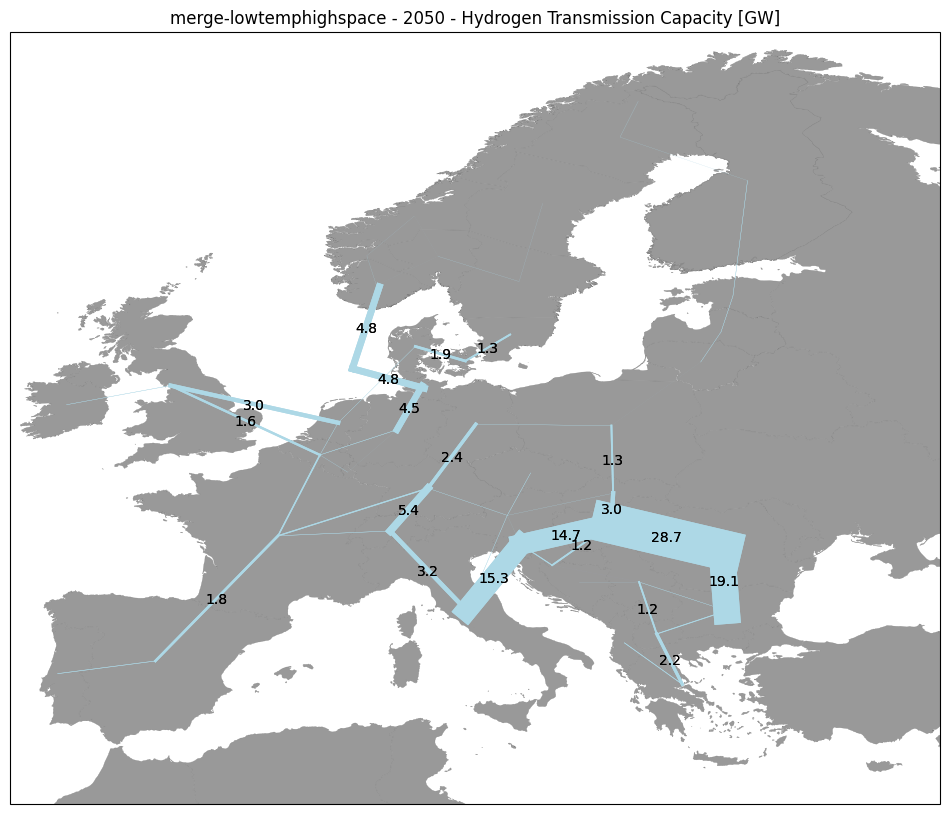

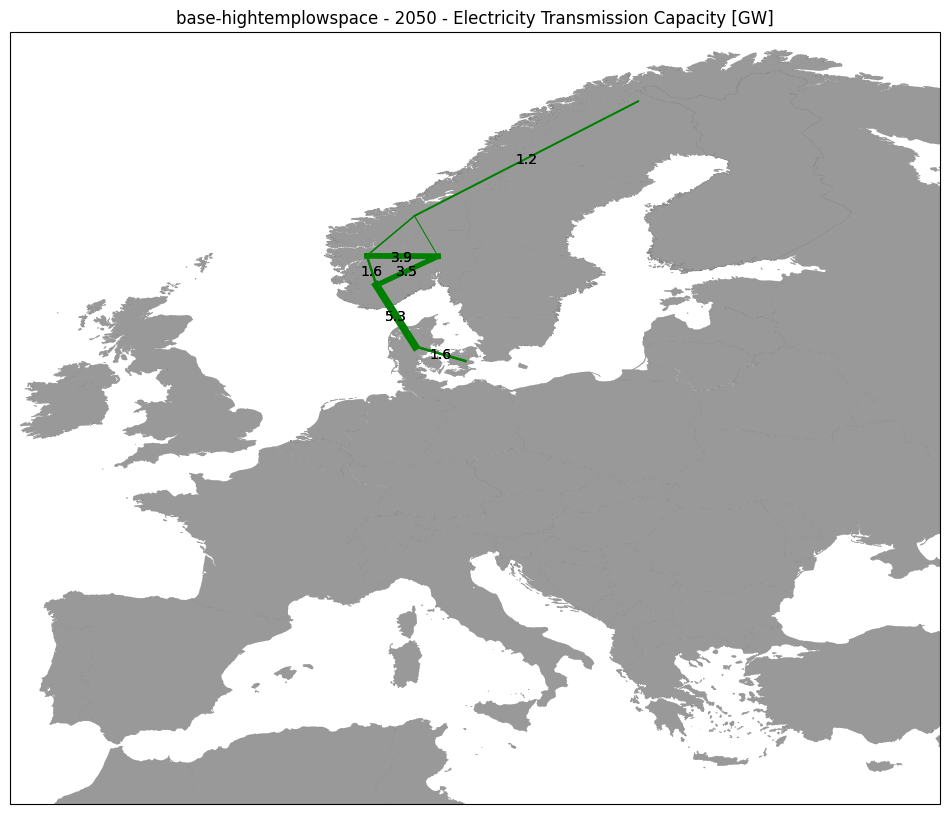

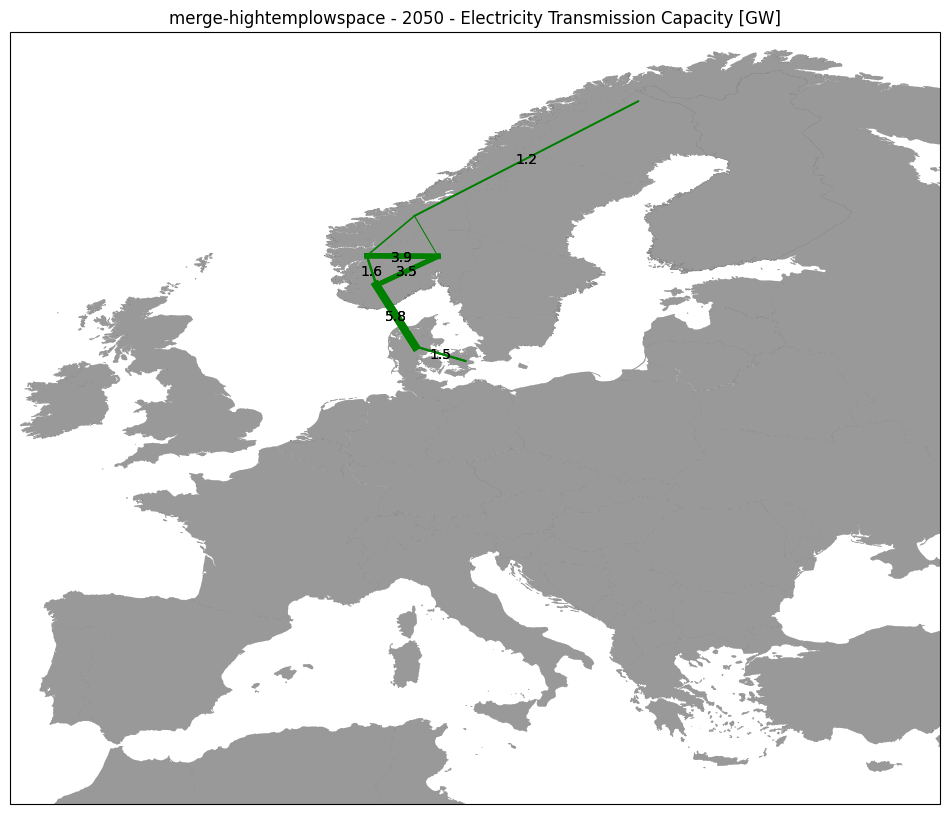

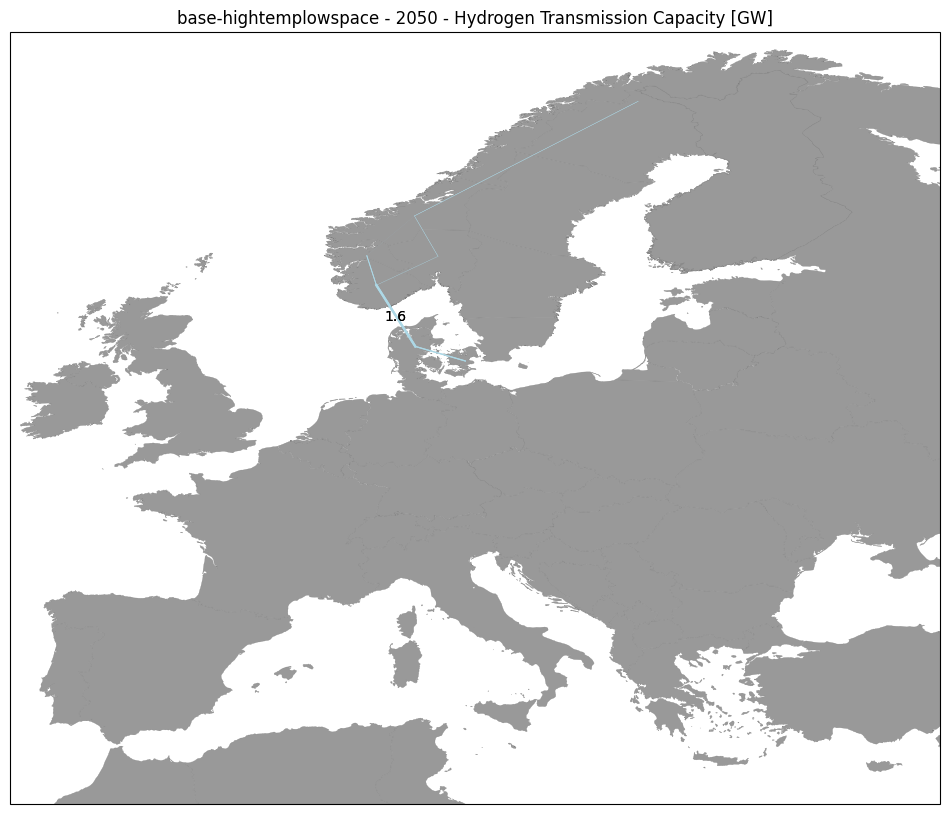

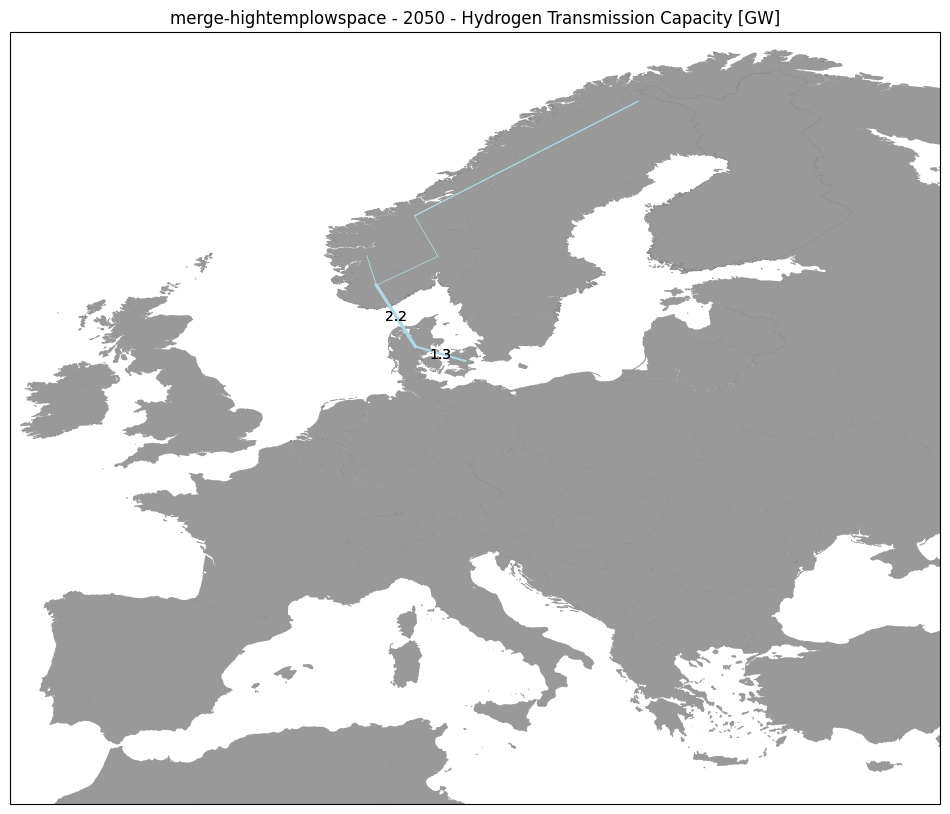

In [18]:
### 2.7 Maps
for test_case in test_cases:
    for carrier in ['Electricity', 'Hydrogen']:
        for scenario in scenarios:
            mr.plot_map('%s-%s'%(scenario, test_case), carrier, 2050)

# KPI's

Key performance indicators are calculated here, i.e. the total change in production, generation- storage- and transmission capacities and objective costs

In [120]:
KPI = pd.DataFrame(index=pd.MultiIndex.from_product((
                    [2030, 2050], 
                    ['Production (TWh)',
                    'Generation Capacities (GW)',
                    'Storage Capacities (GWh)',
                    'El. Transmission Cap (GW)',
                    'System Costs (M€)']
                    )),
                   columns=test_cases)
for year in [2030, 2050]:
    for test_case in test_cases:
        
        # Changed scenario
        pro0 = pro.loc[str(year), (scenarios[1]+'-'+test_case, slice(None))].sum()
        cap0 = cap.loc[str(year), (scenarios[1]+'-'+test_case, slice(None))].sum()
        sto0 = sto.loc[str(year), (scenarios[1]+'-'+test_case, slice(None))].sum()
        eltran0 = eltran.loc[str(year), (scenarios[1]+'-'+test_case)].sum()
        obj0 = obj.loc[str(year), (scenarios[1]+'-'+test_case)].sum()
        
        # Relative to base
        pro0 -= pro.loc[str(year), (scenarios[0]+'-'+test_case, slice(None))].sum()
        cap0 -= cap.loc[str(year), (scenarios[0]+'-'+test_case, slice(None))].sum()
        sto0 -= sto.loc[str(year), (scenarios[0]+'-'+test_case, slice(None))].sum()
        eltran0 -= eltran.loc[str(year), (scenarios[0]+'-'+test_case)].sum()
        obj0 -= obj.loc[str(year), (scenarios[0]+'-'+test_case)].sum()
        
        # Document
        KPI.loc[(year, 'Production (TWh)'), test_case] = pro0
        KPI.loc[(year, 'Generation Capacities (GW)'), test_case] = cap0
        KPI.loc[(year, 'Storage Capacities (GWh)'), test_case] = sto0
        KPI.loc[(year, 'El. Transmission Cap (GW)'), test_case] = eltran0
        KPI.loc[(year, 'System Costs (M€)'), test_case] = obj0

print('Change in KPIs in absolute units for each test case (changed scenario - base scenario)')
print(KPI.astype(float).round(0).astype(int).to_string())

Change in KPIs in absolute units for each test case (changed scenario - base scenario)
                                 lowtemphighspace  hightemplowspace
2030 Production (TWh)                        3601               109
     Generation Capacities (GW)               886                29
     Storage Capacities (GWh)                2648               230
     El. Transmission Cap (GW)                 38                 0
     System Costs (M€)                     101198              2436
2050 Production (TWh)                        4107               142
     Generation Capacities (GW)               907                51
     Storage Capacities (GWh)               39012               267
     El. Transmission Cap (GW)                381                 0
     System Costs (M€)                     129047              3361
